Téléchargement et préparation des données Kaggle

In [1]:
# Installer les dépendances
!pip install kaggle

# Télécharger les données depuis Kaggle
import os
from zipfile import ZipFile

# Charger le fichier kaggle.json (API Key)
api_key_path = "/content/kaggle.json"  # Changez ce chemin si nécessaire
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

# Vérifiez que le fichier API Key est bien disponible
if not os.path.exists(api_key_path):
    print("Veuillez importer votre fichier 'kaggle.json'.")

# Déplacez-le dans le dossier nécessaire
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Téléchargez le dataset
dataset_name = "birdy654/scene-classification-images-and-audio"
!kaggle datasets download -d {dataset_name}

# Décompressez le fichier ZIP téléchargé
zip_file = dataset_name.split('/')[-1] + ".zip"
with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("Données extraites dans le dossier : /content/data")

# Explorer les fichiers
import os
data_dir = "/content/data"
files = os.listdir(data_dir)
print("Fichiers disponibles :", files)

# Charger le fichier CSV pour exploration
import pandas as pd
csv_file = [file for file in files if file.endswith('.csv')][0]
data = pd.read_csv(os.path.join(data_dir, csv_file))
print(data.head())


Veuillez importer votre fichier 'kaggle.json'.
cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/birdy654/scene-classification-images-and-audio
License(s): copyright-authors
 99% 1.60G/1.61G [00:15<00:00, 133MB/s]
100% 1.61G/1.61G [00:15<00:00, 113MB/s]
Données extraites dans le dossier : /content/data
Fichiers disponibles : ['dataset.csv', 'images']
                       IMAGE     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  images/forest/forest0.png  15.795384  -3.442518 -25.316836 -33.412104   
1  images/forest/forest1.png  15.883880  -3.494075 -21.189490 -18.077115   
2  images/forest/forest2.png  17.872629 -18.877467 -31.665319 -47.045579   
3  images/forest/forest3.png  16.843997  -3.527753 -21.282970 -24.248141   
4  images/forest/forest4.png  16.128583  -4.267328 -25.608325 -20.231084   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfc

Exploration des données et visualisation des images

                       IMAGE     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  images/forest/forest0.png  15.795384  -3.442518 -25.316836 -33.412104   
1  images/forest/forest1.png  15.883880  -3.494075 -21.189490 -18.077115   
2  images/forest/forest2.png  17.872629 -18.877467 -31.665319 -47.045579   
3  images/forest/forest3.png  16.843997  -3.527753 -21.282970 -24.248141   
4  images/forest/forest4.png  16.128583  -4.267328 -25.608325 -20.231084   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_97  \
0   2.447290 -46.981182  12.889984 -23.588534 -22.625879  ... -43.876462   
1   4.284962 -27.014271   3.666955  -9.091312  -3.746509  ... -33.883092   
2   1.813430 -45.899877  14.975982 -24.462396  -1.812962  ... -34.456028   
3  27.201589 -18.787674  30.093938  -1.922008  10.156418  ... -36.410615   
4  15.922823 -35.703313  16.307644  -3.547505   4.804142  ... -41.548915   

     mfcc_98    mfcc_99   mfcc_100   mfcc_101   mfcc_102   mfcc_103  \
0  20.697491 -2

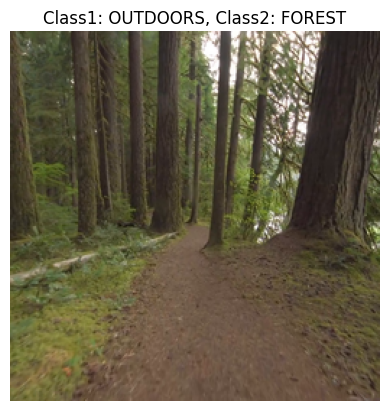

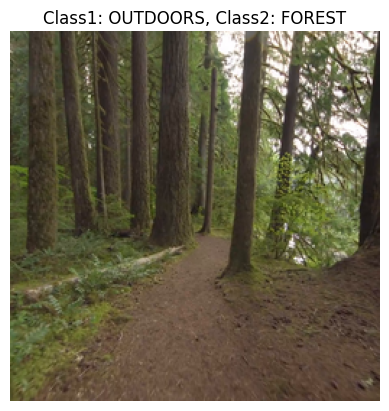

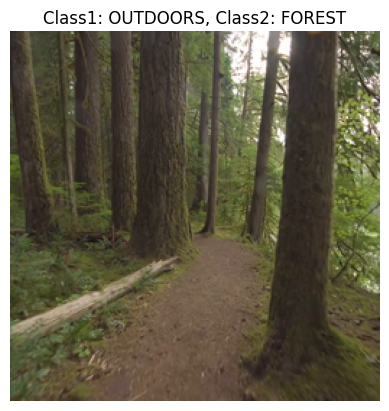

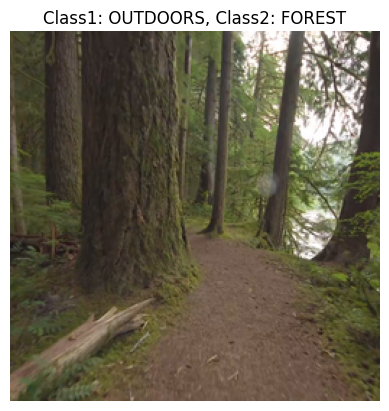

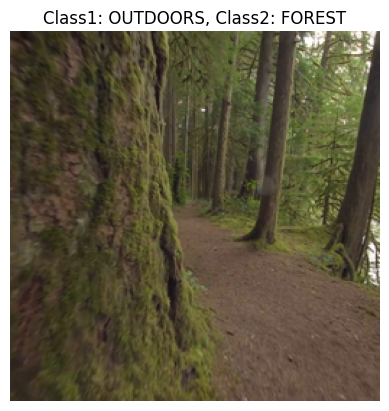

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Charger le dataset
data_path = "/content/data/dataset.csv"
data = pd.read_csv(data_path)

# Afficher les premières lignes
print(data.head())

# Afficher quelques images avec leurs classes
for i in range(5):  # Modifier la plage selon vos besoins
    img_path = f"/content/data/{data['IMAGE'][i]}"
    img = Image.open(img_path)

    # Afficher l'image et les classes associées
    plt.imshow(img)
    plt.title(f"Class1: {data['CLASS1'][i]}, Class2: {data['CLASS2'][i]}")
    plt.axis("off")
    plt.show()


Extraction de caractéristiques à l'aide de ResNet50

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger les données
data_path = "/content/data/dataset.csv"
data = pd.read_csv(data_path)

# Charger le modèle ResNet50 pré-entraîné
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Sélectionner 3 images pour le test
sample_data = data.iloc[400:402]  # Modifier pour travailler sur plus d'images si besoin

# Fonction pour prétraiter et extraire les caractéristiques d'une image
def preprocess_and_extract(image_path):
    # Charger l'image et redimensionner à la taille attendue par ResNet (224x224)
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Extraire les caractéristiques avec ResNet50
    features = resnet_model.predict(img_array)
    return features.flatten()

# Liste pour stocker les résultats
results = []

# Boucle sur les 3 images sélectionnées
for idx, row in sample_data.iterrows():
    img_path = f"/content/data/{row['IMAGE']}"  # Chemin complet de l'image
    features = preprocess_and_extract(img_path)  # Prétraitement et extraction
    results.append([row['IMAGE'], *features, row['CLASS1'], row['CLASS2']])

# Création du DataFrame final
columns = ['IMAGE'] + [f'resnet_feature_{i}' for i in range(1, 2049)] + ['CLASS1', 'CLASS2']
final_df = pd.DataFrame(results, columns=columns)

# Afficher le tableau
print(final_df.head())


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
                         IMAGE  resnet_feature_1  resnet_feature_2  \
0  images/london/london160.png          0.087063          0.118781   
1  images/london/london161.png          0.129221          1.002866   

   resnet_feature_3  resnet_feature_4  resnet_feature_5  resnet_feature_6  \
0          0.120454          1.331041          0.401200          0.357066   
1          0.031812          1.575509          0.096559          0.695811   

   resnet_feature_7  resnet_feature_8  resnet_feature_9  ...  \
0          0.404901          0.905568          1.778039  ...   
1          0.342381          2.012344          1.296158  ...   

   resnet_feature_2041  resnet_feature_2042  resnet_feature_2043  \
0             2.043309             0.138955             0.686727   
1             1.923712             0.000000             0.983436   

   resnet_feature_2044  resnet_fe

**Extraction des caractéristiques par lots avec ResNet50**

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm  # Barre de progression

# Charger les données
data_path = "/content/data/dataset.csv"
data = pd.read_csv(data_path)

# Charger le modèle ResNet50 pré-entraîné
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Fonction pour charger et prétraiter un lot d'images
def preprocess_batch(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(224, 224))  # Charger et redimensionner
        img_array = img_to_array(img)  # Convertir en tableau
        images.append(img_array)
    images = np.array(images)
    images = preprocess_input(images)  # Prétraitement ResNet
    return images

# Paramètres du traitement par lots
batch_size = 32
num_batches = len(data) // batch_size + (len(data) % batch_size != 0)

# Liste pour stocker les résultats
results = []

# Boucle sur les lots avec barre de progression
for batch_idx in tqdm(range(num_batches)):
    # Indices du lot courant
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(data))

    # Obtenir le sous-ensemble de données pour ce lot
    batch_data = data.iloc[start_idx:end_idx]

    # Préparer les chemins complets des images
    image_paths = [f"/content/data/{row['IMAGE']}" for _, row in batch_data.iterrows()]

    try:
        # Charger et prétraiter le lot d'images
        batch_images = preprocess_batch(image_paths)

        # Extraire les caractéristiques pour le lot
        batch_features = resnet_model.predict(batch_images)

        # Ajouter les résultats avec les chemins et les classes
        for idx, row in batch_data.iterrows():
            features = batch_features[idx - start_idx]  # Correspondance des indices
            results.append([row['IMAGE'], *features, row['CLASS1'], row['CLASS2']])
    except Exception as e:
        print(f"Erreur lors du traitement du lot {batch_idx}: {e}")

# Création du DataFrame final
columns = ['IMAGE'] + [f'resnet_feature_{i}' for i in range(1, 2049)] + ['CLASS1', 'CLASS2']
final_df = pd.DataFrame(results, columns=columns)

# Sauvegarder les résultats dans un fichier CSV
output_path = "/content/data/resnet_features_batched.csv"
final_df.to_csv(output_path, index=False)

print(f"Extraction terminée. Résultats enregistrés dans {output_path}")


  0%|          | 0/540 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  0%|          | 1/540 [00:10<1:34:57, 10.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|          | 2/540 [00:21<1:34:28, 10.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  1%|          | 3/540 [00:31<1:34:28, 10.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  1%|          | 4/540 [00:39<1:23:48,  9.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  1%|          | 5/540 [00:45<1:12:55,  8.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  1%|          | 6/540 [00:52<1:10:27,  7.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  1%|▏         | 7/540 [01:03<1:18:07,  8.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  1%|▏         | 8/540 [01:11<1:14:57,  8.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  2%|▏         | 9/540 [01:21<1:20:24,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  2%|▏         | 10/540 [01:27<1:11:36,  8.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  2%|▏         | 11/540 [01:35<1:10:17,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  2%|▏         | 12/540 [01:41<1:05:05,  7.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  2%|▏         | 13/540 [01:56<1:25:48,  9.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  3%|▎         | 14/540 [02:06<1:27:40, 10.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  3%|▎         | 15/540 [02:17<1:28:51, 10.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  3%|▎         | 16/540 [02:28<1:29:48, 10.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  3%|▎         | 17/540 [02:38<1:30:14, 10.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  3%|▎         | 18/540 [02:44<1:18:27,  9.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  4%|▎         | 19/540 [02:52<1:15:21,  8.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  4%|▎         | 20/540 [02:58<1:08:10,  7.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  4%|▍         | 21/540 [03:08<1:14:56,  8.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  4%|▍         | 22/540 [03:14<1:07:41,  7.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  4%|▍         | 23/540 [03:25<1:14:21,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  4%|▍         | 24/540 [03:35<1:18:53,  9.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  5%|▍         | 25/540 [03:41<1:10:06,  8.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  5%|▍         | 26/540 [03:51<1:15:51,  8.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  5%|▌         | 27/540 [03:57<1:08:08,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  5%|▌         | 28/540 [04:08<1:14:38,  8.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  5%|▌         | 29/540 [04:18<1:18:49,  9.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  6%|▌         | 30/540 [04:24<1:10:05,  8.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  6%|▌         | 31/540 [04:32<1:08:35,  8.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  6%|▌         | 32/540 [04:38<1:02:09,  7.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  6%|▌         | 33/540 [04:48<1:10:00,  8.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  6%|▋         | 34/540 [04:59<1:15:29,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  6%|▋         | 35/540 [05:06<1:12:46,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  7%|▋         | 36/540 [05:14<1:10:37,  8.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  7%|▋         | 37/540 [05:25<1:15:41,  9.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  7%|▋         | 38/540 [05:35<1:19:10,  9.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  7%|▋         | 39/540 [05:42<1:12:25,  8.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  7%|▋         | 40/540 [05:53<1:16:49,  9.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  8%|▊         | 41/540 [06:03<1:19:53,  9.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  8%|▊         | 42/540 [06:14<1:21:59,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  8%|▊         | 43/540 [06:20<1:13:55,  8.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  8%|▊         | 44/540 [06:27<1:07:08,  8.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  8%|▊         | 45/540 [06:34<1:05:03,  7.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  9%|▊         | 46/540 [06:44<1:11:17,  8.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  9%|▊         | 47/540 [06:55<1:15:37,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  9%|▉         | 48/540 [07:05<1:18:42,  9.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  9%|▉         | 49/540 [07:13<1:13:15,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  9%|▉         | 50/540 [07:19<1:05:41,  8.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


  9%|▉         | 51/540 [07:27<1:04:55,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 10%|▉         | 52/540 [07:37<1:10:56,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 10%|▉         | 53/540 [07:47<1:15:04,  9.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 10%|█         | 54/540 [07:58<1:18:20,  9.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 10%|█         | 55/540 [08:06<1:13:50,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 10%|█         | 56/540 [08:17<1:17:01,  9.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 11%|█         | 57/540 [08:27<1:19:17,  9.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 11%|█         | 58/540 [08:35<1:13:53,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 11%|█         | 59/540 [08:45<1:16:48,  9.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 11%|█         | 60/540 [08:56<1:18:44,  9.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 11%|█▏        | 61/540 [09:03<1:12:39,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 11%|█▏        | 62/540 [09:14<1:15:48,  9.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 12%|█▏        | 63/540 [09:19<1:06:29,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 12%|█▏        | 64/540 [09:27<1:05:12,  8.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 12%|█▏        | 65/540 [09:38<1:10:23,  8.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 12%|█▏        | 66/540 [09:44<1:04:40,  8.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 12%|█▏        | 67/540 [09:51<1:00:48,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 13%|█▎        | 68/540 [09:58<59:07,  7.52s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 13%|█▎        | 69/540 [10:08<1:05:58,  8.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 13%|█▎        | 70/540 [10:19<1:10:46,  9.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 13%|█▎        | 71/540 [10:29<1:13:59,  9.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 13%|█▎        | 72/540 [10:40<1:16:31,  9.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 14%|█▎        | 73/540 [10:50<1:17:51, 10.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 14%|█▎        | 74/540 [10:56<1:08:45,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 14%|█▍        | 75/540 [11:04<1:05:18,  8.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 14%|█▍        | 76/540 [11:14<1:09:57,  9.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 14%|█▍        | 77/540 [11:20<1:02:04,  8.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 14%|█▍        | 78/540 [11:28<1:01:23,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 15%|█▍        | 79/540 [11:34<56:30,  7.36s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 15%|█▍        | 80/540 [11:44<1:03:38,  8.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 15%|█▌        | 81/540 [11:50<57:48,  7.56s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 15%|█▌        | 82/540 [12:11<1:27:52, 11.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 15%|█▌        | 83/540 [12:21<1:25:33, 11.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 16%|█▌        | 84/540 [12:32<1:23:33, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 16%|█▌        | 85/540 [12:42<1:22:15, 10.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 16%|█▌        | 86/540 [12:48<1:10:45,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 16%|█▌        | 87/540 [12:59<1:13:08,  9.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 16%|█▋        | 88/540 [13:09<1:14:43,  9.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 16%|█▋        | 89/540 [13:20<1:15:45, 10.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 17%|█▋        | 90/540 [13:30<1:16:48, 10.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 17%|█▋        | 91/540 [13:38<1:10:40,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 17%|█▋        | 92/540 [13:44<1:02:34,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 17%|█▋        | 93/540 [13:52<1:01:22,  8.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 17%|█▋        | 94/540 [14:02<1:06:15,  8.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 18%|█▊        | 95/540 [14:08<59:16,  7.99s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 18%|█▊        | 96/540 [14:16<58:27,  7.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 18%|█▊        | 97/540 [14:22<54:12,  7.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 18%|█▊        | 98/540 [14:32<1:01:00,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 18%|█▊        | 99/540 [14:38<55:29,  7.55s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 19%|█▊        | 100/540 [14:46<55:35,  7.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 19%|█▊        | 101/540 [14:52<51:54,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 19%|█▉        | 102/540 [15:00<53:32,  7.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 19%|█▉        | 103/540 [15:05<50:17,  6.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 19%|█▉        | 104/540 [15:13<51:43,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 19%|█▉        | 105/540 [15:24<59:14,  8.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 20%|█▉        | 106/540 [15:34<1:04:08,  8.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 20%|█▉        | 107/540 [15:40<57:47,  8.01s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 20%|██        | 108/540 [15:48<57:22,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 20%|██        | 109/540 [15:54<52:39,  7.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 20%|██        | 110/540 [16:02<53:29,  7.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 21%|██        | 111/540 [16:08<50:12,  7.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 21%|██        | 112/540 [16:18<57:34,  8.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 21%|██        | 113/540 [16:29<1:02:30,  8.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 21%|██        | 114/540 [16:39<1:05:59,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 21%|██▏       | 115/540 [16:45<58:39,  8.28s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 21%|██▏       | 116/540 [16:52<55:59,  7.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 22%|██▏       | 117/540 [16:58<52:27,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 22%|██▏       | 118/540 [17:09<58:59,  8.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 22%|██▏       | 119/540 [17:20<1:03:29,  9.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 22%|██▏       | 120/540 [17:30<1:06:23,  9.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 22%|██▏       | 121/540 [17:37<1:00:06,  8.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 23%|██▎       | 122/540 [17:43<55:20,  7.94s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 23%|██▎       | 123/540 [17:54<1:00:43,  8.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 23%|██▎       | 124/540 [18:02<58:51,  8.49s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 23%|██▎       | 125/540 [18:08<53:34,  7.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 23%|██▎       | 126/540 [18:15<52:26,  7.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 24%|██▎       | 127/540 [18:25<58:32,  8.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 24%|██▎       | 128/540 [18:36<1:02:28,  9.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 24%|██▍       | 129/540 [18:46<1:05:13,  9.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 24%|██▍       | 130/540 [18:52<57:31,  8.42s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 24%|██▍       | 131/540 [19:00<55:51,  8.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 24%|██▍       | 132/540 [19:06<50:54,  7.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 25%|██▍       | 133/540 [19:16<56:54,  8.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 25%|██▍       | 134/540 [19:22<51:41,  7.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 25%|██▌       | 135/540 [19:30<52:00,  7.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 25%|██▌       | 136/540 [19:41<57:31,  8.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 25%|██▌       | 137/540 [19:51<1:01:18,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 26%|██▌       | 138/540 [19:58<57:29,  8.58s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 26%|██▌       | 139/540 [20:04<52:03,  7.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 26%|██▌       | 140/540 [20:12<52:00,  7.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 26%|██▌       | 141/540 [20:18<47:56,  7.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 26%|██▋       | 142/540 [20:28<54:20,  8.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 26%|██▋       | 143/540 [20:34<49:02,  7.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 27%|██▋       | 144/540 [20:45<55:11,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 27%|██▋       | 145/540 [20:55<59:12,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 27%|██▋       | 146/540 [21:06<1:01:58,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 27%|██▋       | 147/540 [21:11<54:47,  8.37s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 27%|██▋       | 148/540 [21:22<58:44,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 28%|██▊       | 149/540 [21:32<1:01:29,  9.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 28%|██▊       | 150/540 [21:39<56:00,  8.62s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 28%|██▊       | 151/540 [21:50<59:31,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 28%|██▊       | 152/540 [22:00<1:01:49,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 28%|██▊       | 153/540 [22:08<57:45,  8.95s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 29%|██▊       | 154/540 [22:18<59:48,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 29%|██▊       | 155/540 [22:24<53:24,  8.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 29%|██▉       | 156/540 [22:32<52:18,  8.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 29%|██▉       | 157/540 [22:37<47:44,  7.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 29%|██▉       | 158/540 [22:45<48:12,  7.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 29%|██▉       | 159/540 [22:51<45:02,  7.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 30%|██▉       | 160/540 [23:02<51:23,  8.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 30%|██▉       | 161/540 [23:07<46:58,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 30%|███       | 162/540 [23:15<47:23,  7.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 30%|███       | 163/540 [23:22<45:50,  7.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 30%|███       | 164/540 [23:30<46:41,  7.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 31%|███       | 165/540 [23:40<52:15,  8.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 31%|███       | 166/540 [23:51<56:11,  9.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 31%|███       | 167/540 [24:01<58:55,  9.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 31%|███       | 168/540 [24:09<54:44,  8.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 31%|███▏      | 169/540 [24:15<49:28,  8.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 31%|███▏      | 170/540 [24:22<47:04,  7.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 32%|███▏      | 171/540 [24:28<45:22,  7.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 32%|███▏      | 172/540 [24:39<50:58,  8.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 32%|███▏      | 173/540 [24:49<54:46,  8.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 32%|███▏      | 174/540 [24:56<50:17,  8.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 32%|███▏      | 175/540 [25:06<54:14,  8.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 33%|███▎      | 176/540 [25:12<48:20,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 33%|███▎      | 177/540 [25:20<47:50,  7.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 33%|███▎      | 178/540 [25:30<52:24,  8.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 33%|███▎      | 179/540 [25:41<55:34,  9.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 33%|███▎      | 180/540 [25:52<57:56,  9.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 34%|███▎      | 181/540 [25:59<54:39,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 34%|███▎      | 182/540 [26:05<48:41,  8.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 34%|███▍      | 183/540 [26:13<47:15,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 34%|███▍      | 184/540 [26:19<43:56,  7.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 34%|███▍      | 185/540 [26:26<42:42,  7.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 34%|███▍      | 186/540 [26:33<42:08,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 35%|███▍      | 187/540 [26:39<40:02,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 35%|███▍      | 188/540 [26:49<46:36,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 35%|███▌      | 189/540 [27:00<50:54,  8.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 35%|███▌      | 190/540 [27:10<53:50,  9.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 35%|███▌      | 191/540 [27:21<55:53,  9.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 36%|███▌      | 192/540 [27:27<49:57,  8.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 36%|███▌      | 193/540 [27:34<46:20,  8.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 36%|███▌      | 194/540 [27:44<50:42,  8.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 36%|███▌      | 195/540 [27:52<48:58,  8.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 36%|███▋      | 196/540 [28:03<52:15,  9.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 36%|███▋      | 197/540 [28:09<47:52,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 37%|███▋      | 198/540 [28:20<51:20,  9.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 37%|███▋      | 199/540 [28:26<46:01,  8.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 37%|███▋      | 200/540 [28:33<45:08,  7.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 37%|███▋      | 201/540 [28:39<41:42,  7.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 37%|███▋      | 202/540 [28:47<42:22,  7.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 38%|███▊      | 203/540 [28:58<47:12,  8.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 38%|███▊      | 204/540 [29:05<44:27,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 38%|███▊      | 205/540 [29:15<48:40,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 38%|███▊      | 206/540 [29:21<43:52,  7.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 38%|███▊      | 207/540 [29:31<48:02,  8.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 39%|███▊      | 208/540 [29:37<43:12,  7.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 39%|███▊      | 209/540 [29:45<42:53,  7.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 39%|███▉      | 210/540 [29:51<39:54,  7.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 39%|███▉      | 211/540 [30:02<45:11,  8.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 39%|███▉      | 212/540 [30:08<41:52,  7.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 39%|███▉      | 213/540 [30:15<41:26,  7.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 40%|███▉      | 214/540 [30:21<38:39,  7.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 40%|███▉      | 215/540 [30:32<44:03,  8.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 40%|████      | 216/540 [30:38<40:54,  7.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 40%|████      | 217/540 [30:45<40:24,  7.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 40%|████      | 218/540 [30:56<45:05,  8.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 41%|████      | 219/540 [31:02<41:12,  7.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 41%|████      | 220/540 [31:10<41:13,  7.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 41%|████      | 221/540 [31:16<37:56,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 41%|████      | 222/540 [31:23<38:44,  7.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 41%|████▏     | 223/540 [31:34<43:45,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 41%|████▏     | 224/540 [31:41<42:06,  8.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 42%|████▏     | 225/540 [31:52<45:55,  8.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 42%|████▏     | 226/540 [32:02<48:29,  9.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 42%|████▏     | 227/540 [32:13<50:16,  9.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 228/540 [32:34<1:08:05, 13.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 42%|████▏     | 229/540 [32:44<1:03:52, 12.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 43%|████▎     | 230/540 [32:50<53:50, 10.42s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 43%|████▎     | 231/540 [33:01<53:47, 10.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 43%|████▎     | 232/540 [33:07<46:46,  9.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 43%|████▎     | 233/540 [33:17<48:55,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 43%|████▎     | 234/540 [33:24<43:48,  8.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 44%|████▎     | 235/540 [33:31<41:22,  8.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 44%|████▎     | 236/540 [33:37<37:56,  7.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 44%|████▍     | 237/540 [33:44<38:03,  7.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 44%|████▍     | 238/540 [33:55<42:23,  8.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 44%|████▍     | 239/540 [34:05<45:21,  9.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 44%|████▍     | 240/540 [34:11<40:21,  8.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 45%|████▍     | 241/540 [34:18<38:36,  7.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 45%|████▍     | 242/540 [34:25<36:39,  7.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 45%|████▌     | 243/540 [34:35<41:09,  8.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 45%|████▌     | 244/540 [34:46<44:16,  8.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 45%|████▌     | 245/540 [34:56<46:20,  9.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 46%|████▌     | 246/540 [35:03<42:00,  8.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 46%|████▌     | 247/540 [35:13<44:43,  9.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 46%|████▌     | 248/540 [35:24<46:30,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 46%|████▌     | 249/540 [35:34<47:40,  9.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 46%|████▋     | 250/540 [35:41<42:39,  8.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 46%|████▋     | 251/540 [35:51<44:52,  9.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 47%|████▋     | 252/540 [36:02<46:25,  9.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 47%|████▋     | 253/540 [36:12<47:23,  9.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 47%|████▋     | 254/540 [36:18<41:53,  8.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 47%|████▋     | 255/540 [36:25<38:37,  8.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 47%|████▋     | 256/540 [36:36<42:00,  8.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 48%|████▊     | 257/540 [36:43<39:47,  8.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 48%|████▊     | 258/540 [36:49<35:53,  7.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 48%|████▊     | 259/540 [36:59<39:48,  8.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 48%|████▊     | 260/540 [37:10<42:25,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 48%|████▊     | 261/540 [37:16<37:50,  8.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 49%|████▊     | 262/540 [37:26<40:57,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 49%|████▊     | 263/540 [37:32<36:21,  7.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 49%|████▉     | 264/540 [37:42<39:50,  8.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 49%|████▉     | 265/540 [37:53<42:10,  9.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 49%|████▉     | 266/540 [37:59<37:35,  8.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 49%|████▉     | 267/540 [38:07<37:05,  8.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 50%|████▉     | 268/540 [38:17<40:07,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 50%|████▉     | 269/540 [38:28<42:11,  9.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 50%|█████     | 270/540 [38:35<39:06,  8.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 50%|█████     | 271/540 [38:41<35:35,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 50%|█████     | 272/540 [38:49<35:02,  7.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 51%|█████     | 273/540 [38:55<32:18,  7.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 51%|█████     | 274/540 [39:05<36:32,  8.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 51%|█████     | 275/540 [39:16<39:25,  8.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 51%|█████     | 276/540 [39:22<35:18,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 51%|█████▏    | 277/540 [39:29<34:59,  7.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 51%|█████▏    | 278/540 [39:40<38:15,  8.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 52%|█████▏    | 279/540 [39:46<34:15,  7.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 52%|█████▏    | 280/540 [39:53<33:05,  7.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 52%|█████▏    | 281/540 [40:03<36:48,  8.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 52%|█████▏    | 282/540 [40:14<39:13,  9.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 52%|█████▏    | 283/540 [40:20<35:32,  8.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 53%|█████▎    | 284/540 [40:31<38:21,  8.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 53%|█████▎    | 285/540 [40:41<40:09,  9.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 53%|█████▎    | 286/540 [40:47<35:09,  8.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 53%|█████▎    | 287/540 [40:55<34:16,  8.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 53%|█████▎    | 288/540 [41:01<31:24,  7.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 54%|█████▎    | 289/540 [41:11<35:03,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 54%|█████▎    | 290/540 [41:17<31:41,  7.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 54%|█████▍    | 291/540 [41:25<31:37,  7.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 54%|█████▍    | 292/540 [41:30<29:11,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 54%|█████▍    | 293/540 [41:38<29:45,  7.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 54%|█████▍    | 294/540 [41:44<27:57,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 55%|█████▍    | 295/540 [41:51<28:20,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 55%|█████▍    | 296/540 [41:57<27:06,  6.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 55%|█████▌    | 297/540 [42:08<31:42,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 55%|█████▌    | 298/540 [42:18<34:49,  8.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 55%|█████▌    | 299/540 [42:29<36:53,  9.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 56%|█████▌    | 300/540 [42:39<38:29,  9.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 56%|█████▌    | 301/540 [42:50<39:25,  9.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 56%|█████▌    | 302/540 [42:57<35:22,  8.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 56%|█████▌    | 303/540 [43:04<32:57,  8.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 56%|█████▋    | 304/540 [43:14<35:25,  9.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 56%|█████▋    | 305/540 [43:20<31:22,  8.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 57%|█████▋    | 306/540 [43:27<30:49,  7.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 57%|█████▋    | 307/540 [43:33<28:15,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 57%|█████▋    | 308/540 [43:41<28:41,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 57%|█████▋    | 309/540 [43:51<32:04,  8.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 57%|█████▋    | 310/540 [43:58<30:21,  7.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 58%|█████▊    | 311/540 [44:09<33:09,  8.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 58%|█████▊    | 312/540 [44:14<29:17,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 58%|█████▊    | 313/540 [44:22<29:10,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 58%|█████▊    | 314/540 [44:33<32:12,  8.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 58%|█████▊    | 315/540 [44:43<34:19,  9.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 59%|█████▊    | 316/540 [44:54<35:40,  9.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 59%|█████▊    | 317/540 [45:04<36:39,  9.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 59%|█████▉    | 318/540 [45:14<36:53,  9.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 59%|█████▉    | 319/540 [45:22<34:08,  9.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 59%|█████▉    | 320/540 [45:28<30:24,  8.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 59%|█████▉    | 321/540 [45:36<29:27,  8.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 60%|█████▉    | 322/540 [45:41<26:50,  7.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 60%|█████▉    | 323/540 [45:49<26:54,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 60%|██████    | 324/540 [46:00<30:06,  8.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 60%|██████    | 325/540 [46:05<27:25,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 60%|██████    | 326/540 [46:13<27:17,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 61%|██████    | 327/540 [46:24<30:19,  8.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 61%|██████    | 328/540 [46:30<28:00,  7.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 61%|██████    | 329/540 [46:37<26:24,  7.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 61%|██████    | 330/540 [46:44<25:42,  7.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 61%|██████▏   | 331/540 [46:54<28:55,  8.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 61%|██████▏   | 332/540 [47:05<31:02,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 62%|██████▏   | 333/540 [47:11<27:40,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 62%|██████▏   | 334/540 [47:18<27:14,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 62%|██████▏   | 335/540 [47:29<29:43,  8.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 62%|██████▏   | 336/540 [47:36<27:48,  8.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 62%|██████▏   | 337/540 [47:42<25:13,  7.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 63%|██████▎   | 338/540 [47:49<25:00,  7.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 63%|██████▎   | 339/540 [47:55<23:30,  7.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 63%|██████▎   | 340/540 [48:02<23:50,  7.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 63%|██████▎   | 341/540 [48:08<22:21,  6.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 63%|██████▎   | 342/540 [48:16<23:03,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 64%|██████▎   | 343/540 [48:26<26:22,  8.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 64%|██████▎   | 344/540 [48:32<23:56,  7.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 64%|██████▍   | 345/540 [48:39<23:40,  7.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 64%|██████▍   | 346/540 [48:45<22:11,  6.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 64%|██████▍   | 347/540 [48:51<21:40,  6.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 64%|██████▍   | 348/540 [48:58<21:44,  6.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 65%|██████▍   | 349/540 [49:04<20:51,  6.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 65%|██████▍   | 350/540 [49:12<21:28,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 65%|██████▌   | 351/540 [49:18<20:26,  6.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 65%|██████▌   | 352/540 [49:25<21:15,  6.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 65%|██████▌   | 353/540 [49:31<20:13,  6.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 66%|██████▌   | 354/540 [49:41<23:49,  7.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 66%|██████▌   | 355/540 [49:47<21:55,  7.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 66%|██████▌   | 356/540 [49:58<24:56,  8.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 66%|██████▌   | 357/540 [50:05<23:44,  7.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 66%|██████▋   | 358/540 [50:15<26:12,  8.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 66%|██████▋   | 359/540 [50:23<25:00,  8.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 67%|██████▋   | 360/540 [50:33<26:51,  8.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 67%|██████▋   | 361/540 [50:39<24:00,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 67%|██████▋   | 362/540 [50:47<23:29,  7.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 67%|██████▋   | 363/540 [50:57<25:37,  8.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 67%|██████▋   | 364/540 [51:04<23:42,  8.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 68%|██████▊   | 365/540 [51:14<25:38,  8.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 68%|██████▊   | 366/540 [51:20<22:49,  7.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 68%|██████▊   | 367/540 [51:28<22:31,  7.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 68%|██████▊   | 368/540 [51:38<24:41,  8.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 68%|██████▊   | 369/540 [51:49<26:08,  9.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 69%|██████▊   | 370/540 [51:56<24:03,  8.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 69%|██████▊   | 371/540 [52:06<25:36,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 69%|██████▉   | 372/540 [52:16<26:35,  9.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 69%|██████▉   | 373/540 [52:27<27:16,  9.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 69%|██████▉   | 374/540 [52:33<24:18,  8.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 69%|██████▉   | 375/540 [52:40<22:03,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 70%|██████▉   | 376/540 [52:47<21:07,  7.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 70%|██████▉   | 377/540 [52:53<19:29,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 70%|███████   | 378/540 [53:03<22:02,  8.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 70%|███████   | 379/540 [53:14<23:45,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 70%|███████   | 380/540 [53:19<21:05,  7.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 71%|███████   | 381/540 [53:30<23:01,  8.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 71%|███████   | 382/540 [53:40<24:18,  9.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 71%|███████   | 383/540 [53:46<21:27,  8.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 71%|███████   | 384/540 [53:54<20:49,  8.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 71%|███████▏  | 385/540 [53:59<19:02,  7.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 71%|███████▏  | 386/540 [54:07<19:07,  7.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 72%|███████▏  | 387/540 [54:18<21:22,  8.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 72%|███████▏  | 388/540 [54:24<19:40,  7.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 72%|███████▏  | 389/540 [54:34<21:35,  8.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 72%|███████▏  | 390/540 [54:40<19:21,  7.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 72%|███████▏  | 391/540 [54:48<19:03,  7.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 73%|███████▎  | 392/540 [54:54<17:34,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 73%|███████▎  | 393/540 [55:04<19:55,  8.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 73%|███████▎  | 394/540 [55:15<21:30,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 73%|███████▎  | 395/540 [55:20<19:14,  7.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 73%|███████▎  | 396/540 [55:31<20:56,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 74%|███████▎  | 397/540 [55:37<18:57,  7.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 74%|███████▎  | 398/540 [55:44<18:18,  7.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 74%|███████▍  | 399/540 [55:50<16:51,  7.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 74%|███████▍  | 400/540 [56:01<19:03,  8.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 74%|███████▍  | 401/540 [56:07<17:45,  7.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 74%|███████▍  | 402/540 [56:14<16:52,  7.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 75%|███████▍  | 403/540 [56:24<18:54,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 75%|███████▍  | 404/540 [56:35<20:32,  9.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 75%|███████▌  | 405/540 [56:46<21:25,  9.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 75%|███████▌  | 406/540 [56:53<19:45,  8.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 75%|███████▌  | 407/540 [56:59<17:22,  7.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 76%|███████▌  | 408/540 [57:06<16:44,  7.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 76%|███████▌  | 409/540 [57:16<18:28,  8.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 76%|███████▌  | 410/540 [57:22<16:55,  7.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 76%|███████▌  | 411/540 [57:33<18:29,  8.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 76%|███████▋  | 412/540 [57:38<16:27,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 76%|███████▋  | 413/540 [57:46<16:09,  7.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 77%|███████▋  | 414/540 [57:52<14:47,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 77%|███████▋  | 415/540 [57:59<14:54,  7.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 77%|███████▋  | 416/540 [58:05<13:54,  6.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 77%|███████▋  | 417/540 [58:11<13:46,  6.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 77%|███████▋  | 418/540 [58:17<13:17,  6.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 78%|███████▊  | 419/540 [58:23<12:42,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 78%|███████▊  | 420/540 [58:31<13:11,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 78%|███████▊  | 421/540 [58:36<12:24,  6.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 78%|███████▊  | 422/540 [58:43<12:52,  6.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 78%|███████▊  | 423/540 [58:49<12:09,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 79%|███████▊  | 424/540 [58:56<12:45,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 79%|███████▊  | 425/540 [59:02<12:03,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 79%|███████▉  | 426/540 [59:09<12:26,  6.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 79%|███████▉  | 427/540 [59:15<11:53,  6.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 79%|███████▉  | 428/540 [59:21<11:54,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 79%|███████▉  | 429/540 [59:32<14:09,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 80%|███████▉  | 430/540 [59:39<13:56,  7.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 80%|███████▉  | 431/540 [59:45<12:38,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 80%|████████  | 432/540 [59:52<12:36,  7.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 80%|████████  | 433/540 [59:58<11:57,  6.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 80%|████████  | 434/540 [1:00:08<13:51,  7.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 81%|████████  | 435/540 [1:00:14<12:40,  7.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 81%|████████  | 436/540 [1:00:25<14:17,  8.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 81%|████████  | 437/540 [1:00:31<13:14,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 81%|████████  | 438/540 [1:00:39<12:53,  7.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 81%|████████▏ | 439/540 [1:00:49<14:14,  8.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 81%|████████▏ | 440/540 [1:01:00<15:06,  9.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 82%|████████▏ | 441/540 [1:01:10<15:39,  9.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 82%|████████▏ | 442/540 [1:01:16<13:51,  8.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 82%|████████▏ | 443/540 [1:01:27<14:42,  9.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 82%|████████▏ | 444/540 [1:01:37<15:13,  9.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 82%|████████▏ | 445/540 [1:01:48<15:31,  9.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 83%|████████▎ | 446/540 [1:01:58<15:44, 10.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 83%|████████▎ | 447/540 [1:02:09<15:48, 10.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 83%|████████▎ | 448/540 [1:02:16<14:15,  9.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 83%|████████▎ | 449/540 [1:02:22<12:36,  8.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 83%|████████▎ | 450/540 [1:02:29<11:48,  7.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 84%|████████▎ | 451/540 [1:02:40<12:55,  8.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 84%|████████▎ | 452/540 [1:02:50<13:34,  9.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 84%|████████▍ | 453/540 [1:02:56<12:04,  8.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 84%|████████▍ | 454/540 [1:03:04<11:32,  8.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 84%|████████▍ | 455/540 [1:03:14<12:28,  8.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 84%|████████▍ | 456/540 [1:03:20<11:07,  7.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 85%|████████▍ | 457/540 [1:03:31<12:02,  8.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 85%|████████▍ | 458/540 [1:03:41<12:37,  9.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 85%|████████▌ | 459/540 [1:03:52<12:58,  9.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 85%|████████▌ | 460/540 [1:03:57<11:16,  8.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 85%|████████▌ | 461/540 [1:04:08<11:56,  9.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 86%|████████▌ | 462/540 [1:04:14<10:31,  8.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 86%|████████▌ | 463/540 [1:04:24<11:19,  8.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 86%|████████▌ | 464/540 [1:04:35<11:49,  9.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 86%|████████▌ | 465/540 [1:04:41<10:24,  8.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 86%|████████▋ | 466/540 [1:04:51<11:04,  8.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 86%|████████▋ | 467/540 [1:05:02<11:28,  9.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 87%|████████▋ | 468/540 [1:05:08<10:02,  8.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 87%|████████▋ | 469/540 [1:05:15<09:26,  7.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 87%|████████▋ | 470/540 [1:05:25<10:10,  8.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 87%|████████▋ | 471/540 [1:05:31<08:55,  7.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 87%|████████▋ | 472/540 [1:05:37<08:24,  7.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 88%|████████▊ | 473/540 [1:05:43<07:50,  7.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 88%|████████▊ | 474/540 [1:05:49<07:18,  6.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 88%|████████▊ | 475/540 [1:06:00<08:28,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 88%|████████▊ | 476/540 [1:06:07<08:06,  7.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 88%|████████▊ | 477/540 [1:06:12<07:21,  7.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 89%|████████▊ | 478/540 [1:06:18<06:53,  6.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 89%|████████▊ | 479/540 [1:06:25<06:51,  6.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


 89%|████████▉ | 480/540 [1:06:33<07:07,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 89%|████████▉ | 481/540 [1:06:43<07:42,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 89%|████████▉ | 482/540 [1:06:48<06:53,  7.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 89%|████████▉ | 483/540 [1:06:59<07:44,  8.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 90%|████████▉ | 484/540 [1:07:06<07:17,  7.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 90%|████████▉ | 485/540 [1:07:12<06:44,  7.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 90%|█████████ | 486/540 [1:07:23<07:27,  8.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 90%|█████████ | 487/540 [1:07:28<06:34,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 90%|█████████ | 488/540 [1:07:38<07:14,  8.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 91%|█████████ | 489/540 [1:07:44<06:23,  7.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 91%|█████████ | 490/540 [1:07:51<06:10,  7.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 91%|█████████ | 491/540 [1:07:57<05:37,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 91%|█████████ | 492/540 [1:08:04<05:35,  6.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 91%|█████████▏| 493/540 [1:08:10<05:12,  6.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 91%|█████████▏| 494/540 [1:08:17<05:16,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 92%|█████████▏| 495/540 [1:08:23<04:54,  6.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 92%|█████████▏| 496/540 [1:08:30<04:50,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 92%|█████████▏| 497/540 [1:08:36<04:37,  6.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 92%|█████████▏| 498/540 [1:08:42<04:21,  6.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 92%|█████████▏| 499/540 [1:08:48<04:22,  6.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 93%|█████████▎| 500/540 [1:08:54<04:02,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 93%|█████████▎| 501/540 [1:09:01<04:09,  6.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 93%|█████████▎| 502/540 [1:09:07<03:55,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 93%|█████████▎| 503/540 [1:09:14<04:01,  6.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 93%|█████████▎| 504/540 [1:09:20<03:45,  6.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 94%|█████████▎| 505/540 [1:09:26<03:43,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 94%|█████████▎| 506/540 [1:09:37<04:19,  7.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 94%|█████████▍| 507/540 [1:09:44<04:07,  7.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 94%|█████████▍| 508/540 [1:09:50<03:42,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 94%|█████████▍| 509/540 [1:09:57<03:38,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 94%|█████████▍| 510/540 [1:10:03<03:20,  6.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 95%|█████████▍| 511/540 [1:10:10<03:22,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 95%|█████████▍| 512/540 [1:10:16<03:03,  6.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 95%|█████████▌| 513/540 [1:10:27<03:29,  7.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 95%|█████████▌| 514/540 [1:10:32<03:05,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 95%|█████████▌| 515/540 [1:10:39<02:58,  7.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 96%|█████████▌| 516/540 [1:10:45<02:39,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 96%|█████████▌| 517/540 [1:10:52<02:38,  6.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 96%|█████████▌| 518/540 [1:10:58<02:23,  6.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 96%|█████████▌| 519/540 [1:11:09<02:42,  7.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 96%|█████████▋| 520/540 [1:11:14<02:22,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 96%|█████████▋| 521/540 [1:11:21<02:15,  7.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 97%|█████████▋| 522/540 [1:11:27<02:01,  6.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 97%|█████████▋| 523/540 [1:11:38<02:13,  7.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 97%|█████████▋| 524/540 [1:11:43<01:55,  7.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 97%|█████████▋| 525/540 [1:11:51<01:47,  7.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 97%|█████████▋| 526/540 [1:11:56<01:33,  6.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 98%|█████████▊| 527/540 [1:12:03<01:29,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 98%|█████████▊| 528/540 [1:12:09<01:17,  6.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 98%|█████████▊| 529/540 [1:12:16<01:13,  6.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 98%|█████████▊| 530/540 [1:12:22<01:03,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 98%|█████████▊| 531/540 [1:12:32<01:08,  7.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 99%|█████████▊| 532/540 [1:12:38<00:55,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 99%|█████████▊| 533/540 [1:12:48<00:56,  8.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


 99%|█████████▉| 534/540 [1:12:54<00:44,  7.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


 99%|█████████▉| 535/540 [1:13:01<00:36,  7.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 99%|█████████▉| 536/540 [1:13:12<00:32,  8.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


 99%|█████████▉| 537/540 [1:13:17<00:22,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


100%|█████████▉| 538/540 [1:13:25<00:14,  7.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


100%|█████████▉| 539/540 [1:13:30<00:06,  6.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


100%|██████████| 540/540 [1:13:35<00:00,  8.18s/it]


Extraction terminée. Résultats enregistrés dans /content/data/resnet_features_batched.csv


Exploration des données extraites

In [4]:
import pandas as pd

# Chemin vers le fichier CSV
file_path = "/content/data/resnet_features_batched.csv"

# Lire le fichier CSV
data = pd.read_csv(file_path)

# Afficher les premières lignes du fichier
#print(data.head())
print(data.tail())

# Vérifier les informations générales sur le fichier
print(data.info())

# Afficher les colonnes disponibles
print("Colonnes disponibles :", data.columns)

# Vérifier la taille des données
print("Nombre d'images :", len(data))


                               IMAGE  resnet_feature_1  resnet_feature_2  \
17247  images/store4/store4-1026.png          0.112571          1.425770   
17248  images/store4/store4-1027.png          0.094659          1.022106   
17249  images/store4/store4-1028.png          0.027010          0.677925   
17250  images/store4/store4-1029.png          0.045566          0.366073   
17251  images/store4/store4-1030.png          0.000000          0.522036   

       resnet_feature_3  resnet_feature_4  resnet_feature_5  resnet_feature_6  \
17247          0.021403          3.148748          0.574647          0.200646   
17248          0.146570          3.470935          0.725424          0.275891   
17249          0.801562          3.148029          0.220630          0.099831   
17250          0.797415          2.599565          0.210384          0.260174   
17251          0.630530          1.278756          0.194152          0.268676   

       resnet_feature_7  resnet_feature_8  resnet_featur

Téléchargement du fichier contenant les caractéristiques extraites

In [5]:
from google.colab import files

# Spécifiez le chemin du fichier que vous souhaitez télécharger
file_path = "/content/data/resnet_features_batched.csv"

# Télécharger le fichier
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelisation

Préparation des Données pour la Classification Basée sur les Caractéristiques Extraites

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Charger les données extraites de ResNet
merged_data = pd.read_csv('/content/data/resnet_features_batched.csv')

# Sélectionner les caractéristiques (features) et les labels
X_image = merged_data.drop(columns=['IMAGE', 'CLASS1', 'CLASS2'])  # Caractéristiques des images
y_image = merged_data['CLASS2']  # Labels des classes d'images

# Encoder les labels de classe
label_encoder = LabelEncoder()
y_image_encoded = label_encoder.fit_transform(y_image)

# Diviser en ensembles d'entraînement et de test
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_image, y_image_encoded, test_size=0.2, random_state=42)

# Reshaper les caractéristiques pour l'entrée CNN
X_train_img = X_train_img.values.reshape((-1, X_train_img.shape[1], 1))  # (nombre d'exemples, caractéristiques, 1)
X_test_img = X_test_img.values.reshape((-1, X_test_img.shape[1], 1))  # (nombre d'exemples, caractéristiques, 1)

# Afficher la forme des données
print(X_train_img.shape, X_test_img.shape)


(13801, 2048, 1) (3451, 2048, 1)


Création et Compilation du Modèle de Réseau de Neurones Convolutifs (CNN) pour la Classification d'Images

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Créer le modèle CNN
model_img = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_img.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Nombre de classes dans y_image_encoded
])

# Compiler le modèle
model_img.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumer le modèle
model_img.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2046, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1023, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1021, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 510, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65280)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,355,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,382,089 (31.98 MB)

 Trainable params: 8,382,089 (31.98 MB)

 Non-trainable params: 0 (0.00 B)

Entraînement et Évaluation du Modèle CNN pour la Classification d'Images

Epoch 1/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 98s 224ms/step - accuracy: 0.9078 - loss: 0.3248 - val_accuracy: 0.9933 - val_loss: 0.0226
Epoch 2/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 96s 223ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9913 - val_loss: 0.0256
Epoch 3/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 146s 232ms/step - accuracy: 0.9982 - loss: 0.0057 - val_accuracy: 0.9884 - val_loss: 0.0453
Epoch 4/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 135s 215ms/step - accuracy: 0.9966 - loss: 0.0087 - val_accuracy: 0.9962 - val_loss: 0.0191
Epoch 5/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 143s 217ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9951 - val_loss: 0.0218
Epoch 6/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 94s 218ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9957 - val_loss: 0.0183
Epoch 7/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 142s 219ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9962 - val_loss: 0.0162
Epoch 8/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 94s 218ms/step - accuracy: 0.9993 - los

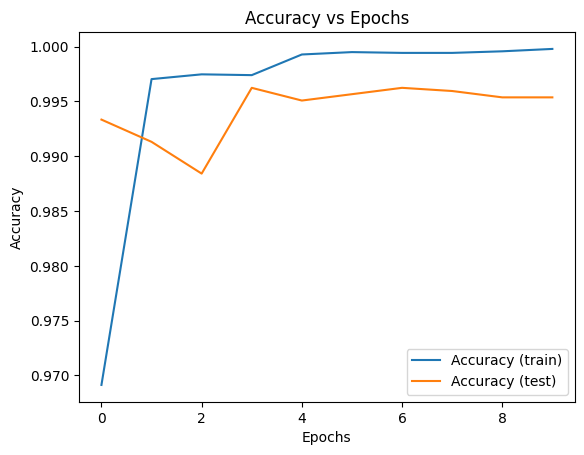

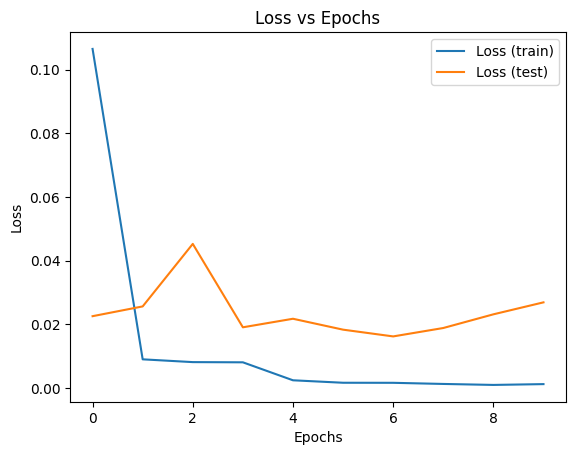

In [8]:
# Entraîner le modèle
history = model_img.fit(X_train_img, y_train_img, epochs=10, batch_size=32, validation_data=(X_test_img, y_test_img))

# Afficher les courbes d'apprentissage (si souhaité)
import matplotlib.pyplot as plt

# Courbes de perte et d'exactitude
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (test)')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (test)')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Évaluation de la Performance du Modèle sur l'Ensemble de Test


In [9]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_acc = model_img.evaluate(X_test_img, y_test_img, verbose=2)
print(f"Test accuracy: {test_acc}")


108/108 - 5s - 50ms/step - accuracy: 0.9954 - loss: 0.0269
Test accuracy: 0.9953636527061462


108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


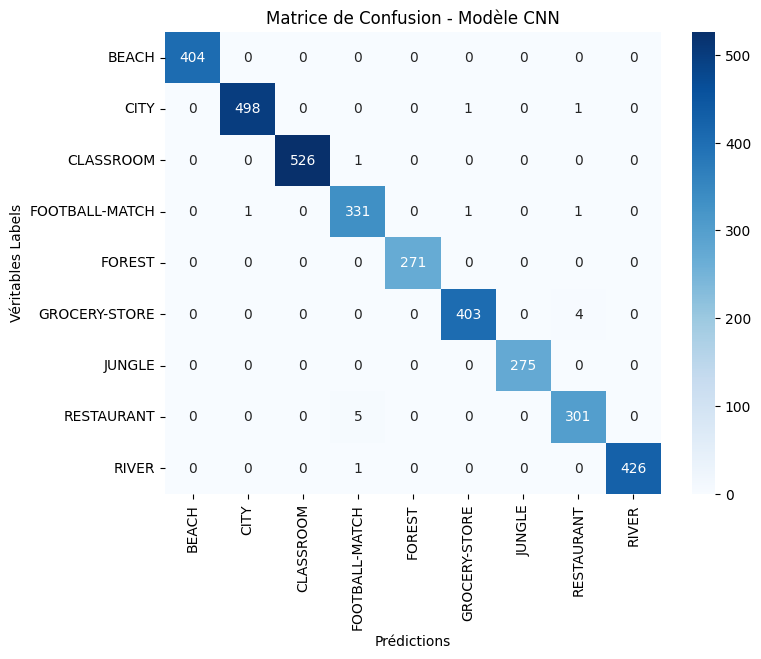

Classification Report:
                precision    recall  f1-score   support

         BEACH       1.00      1.00      1.00       404
          CITY       1.00      1.00      1.00       500
     CLASSROOM       1.00      1.00      1.00       527
FOOTBALL-MATCH       0.98      0.99      0.99       334
        FOREST       1.00      1.00      1.00       271
 GROCERY-STORE       1.00      0.99      0.99       407
        JUNGLE       1.00      1.00      1.00       275
    RESTAURANT       0.98      0.98      0.98       306
         RIVER       1.00      1.00      1.00       427

      accuracy                           1.00      3451
     macro avg       0.99      1.00      0.99      3451
  weighted avg       1.00      1.00      1.00      3451

108/108 - 5s - 49ms/step - accuracy: 0.9954 - loss: 0.0269
Test accuracy: 0.9954
Test loss: 0.0269


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prédictions sur l'ensemble de test
y_pred_img = model_img.predict(X_test_img)

# Convertir les prédictions en classes
y_pred_img_classes = np.argmax(y_pred_img, axis=1)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test_img, y_pred_img_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de Confusion - Modèle CNN")
plt.xlabel("Prédictions")
plt.ylabel("Véritables Labels")
plt.show()

# Rapport de classification
print("Classification Report:")
print(classification_report(y_test_img, y_pred_img_classes, target_names=label_encoder.classes_))

# Optionnel : Afficher la précision et la perte du modèle sur l'ensemble de test
test_loss, test_acc = model_img.evaluate(X_test_img, y_test_img, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")




modèle audio


Préparation des Données Audio : Sélection des Caractéristiques (MFCC) et des Labels


In [13]:
import pandas as pd

# Charger le fichier CSV
audio_data = pd.read_csv('/content/data/dataset.csv')

# Afficher les premières lignes pour inspecter la structure des données
print(audio_data.head())

                       IMAGE     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  images/forest/forest0.png  15.795384  -3.442518 -25.316836 -33.412104   
1  images/forest/forest1.png  15.883880  -3.494075 -21.189490 -18.077115   
2  images/forest/forest2.png  17.872629 -18.877467 -31.665319 -47.045579   
3  images/forest/forest3.png  16.843997  -3.527753 -21.282970 -24.248141   
4  images/forest/forest4.png  16.128583  -4.267328 -25.608325 -20.231084   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_97  \
0   2.447290 -46.981182  12.889984 -23.588534 -22.625879  ... -43.876462   
1   4.284962 -27.014271   3.666955  -9.091312  -3.746509  ... -33.883092   
2   1.813430 -45.899877  14.975982 -24.462396  -1.812962  ... -34.456028   
3  27.201589 -18.787674  30.093938  -1.922008  10.156418  ... -36.410615   
4  15.922823 -35.703313  16.307644  -3.547505   4.804142  ... -41.548915   

     mfcc_98    mfcc_99   mfcc_100   mfcc_101   mfcc_102   mfcc_103  \
0  20.697491 -2

In [14]:
# Sélectionner les caractéristiques (MFCC) et les labels
X_audio = audio_data.drop(columns=['IMAGE', 'CLASS1', 'CLASS2'])  # Suppression des colonnes non nécessaires
y_audio = audio_data['CLASS2']  # Labels des classes d'audio (par exemple, FOREST, CITY, etc.)

# Afficher les premières lignes pour vérifier
print(X_audio.head(), y_audio.head())


      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0  15.795384  -3.442518 -25.316836 -33.412104   2.447290 -46.981182   
1  15.883880  -3.494075 -21.189490 -18.077115   4.284962 -27.014271   
2  17.872629 -18.877467 -31.665319 -47.045579   1.813430 -45.899877   
3  16.843997  -3.527753 -21.282970 -24.248141  27.201589 -18.787674   
4  16.128583  -4.267328 -25.608325 -20.231084  15.922823 -35.703313   

      mfcc_7     mfcc_8     mfcc_9    mfcc_10  ...    mfcc_95    mfcc_96  \
0  12.889984 -23.588534 -22.625879  -8.265216  ... -23.497892   8.794119   
1   3.666955  -9.091312  -3.746509  -3.116524  ... -21.798273  31.687070   
2  14.975982 -24.462396  -1.812962 -24.628896  ... -24.836242  17.282080   
3  30.093938  -1.922008  10.156418 -11.830527  ... -28.511534  17.568753   
4  16.307644  -3.547505   4.804142  -3.261331  ... -27.281700  18.550420   

     mfcc_97    mfcc_98    mfcc_99   mfcc_100   mfcc_101   mfcc_102  \
0 -43.876462  20.697491 -22.793173  -9.417196

Encodage des Labels Audio en Valeurs Numériques

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
y_audio_encoded = label_encoder.fit_transform(y_audio)

# Afficher les valeurs encodées
print(y_audio_encoded[:5])  # Exemple des 5 premières valeurs encodées


[4 4 4 4 4]



Reshaping des Données Audio pour l'Entrée du Modèle

In [16]:
import numpy as np

# Reshaper les données pour qu'elles aient la forme (samples, timesteps, features)
X_audio_reshaped = X_audio.values.reshape(X_audio.shape[0], X_audio.shape[1], 1)  # 1 pour les caractéristiques par timestep

# Vérifier le nouveau shape
print(X_audio_reshaped.shape)


(17252, 104, 1)


Division des Données Audio en Ensembles d'Entraînement et de Test

In [17]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_audio_reshaped, y_audio_encoded, test_size=0.2, random_state=42)

# Vérifier les formes des ensembles d'entraînement et de test
print(X_train.shape, X_test.shape)


(13801, 104, 1) (3451, 104, 1)



Création et Entraînement d'un Modèle LSTM pour la Classification Audio

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Créer le modèle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))  # 64 unités LSTM
model_lstm.add(Dropout(0.2))  # Dropout pour éviter le sur-apprentissage
model_lstm.add(LSTM(32))  # Deuxième couche LSTM avec 32 unités
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Utilisation de 'softmax' pour classification multi-classes

# Compiler le modèle
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


432/432 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - accuracy: 0.2403 - loss: 1.9796
Epoch 2/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - accuracy: 0.4526 - loss: 1.5005
Epoch 3/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.5391 - loss: 1.3265
Epoch 4/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.6325 - loss: 1.1014
Epoch 5/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.6895 - loss: 0.9267
Epoch 6/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.7391 - loss: 0.8057
Epoch 7/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7712 - loss: 0.7124
Epoch 8/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.7998 - loss: 0.6175
Epoch 9/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.8149 - loss: 0.5842
Epoch 10/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.8395 - loss: 0.5134


Évaluation du Modèle LSTM sur l'Ensemble de Test pour la Prédiction Audio

In [19]:
# Prédire sur l'ensemble de test
y_pred = model_lstm.predict(X_test)

# Convertir les prédictions en classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculer l'accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Accuracy: 84.24%



Affichage des Prédictions et des Étiquettes Réelles pour l'Évaluation du Modèle LSTM

In [20]:
# Afficher les prédictions par rapport aux vraies étiquettes
predicted_labels = label_encoder.inverse_transform(y_pred_classes)
true_labels = label_encoder.inverse_transform(y_test)

# Exemple des premières prédictions
print("Predictions:", predicted_labels[:5])
print("True labels:", true_labels[:5])


Predictions: ['RIVER' 'GROCERY-STORE' 'CLASSROOM' 'FOREST' 'RESTAURANT']
True labels: ['RIVER' 'GROCERY-STORE' 'CLASSROOM' 'RIVER' 'RESTAURANT']


108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


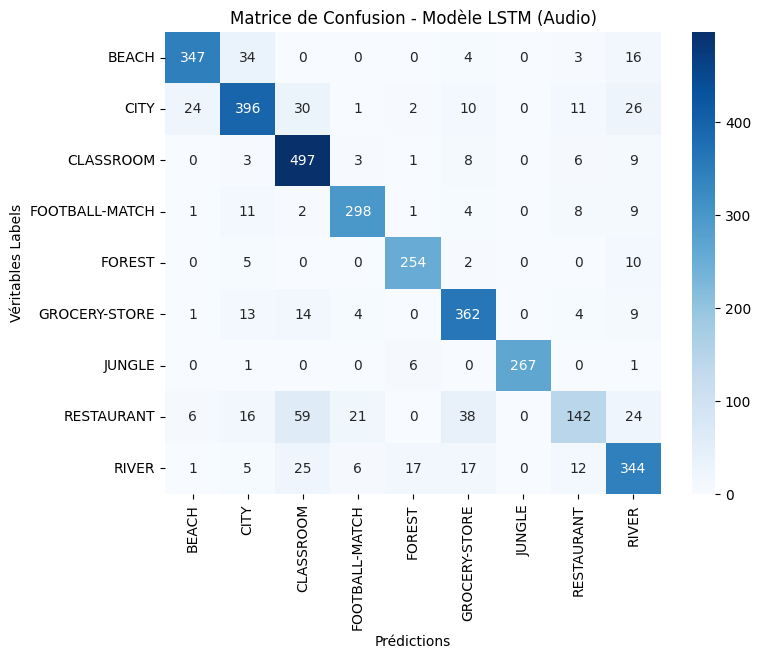

Classification Report - Modèle LSTM (Audio):
                precision    recall  f1-score   support

         BEACH       0.91      0.86      0.89       404
          CITY       0.82      0.79      0.80       500
     CLASSROOM       0.79      0.94      0.86       527
FOOTBALL-MATCH       0.89      0.89      0.89       334
        FOREST       0.90      0.94      0.92       271
 GROCERY-STORE       0.81      0.89      0.85       407
        JUNGLE       1.00      0.97      0.99       275
    RESTAURANT       0.76      0.46      0.58       306
         RIVER       0.77      0.81      0.79       427

      accuracy                           0.84      3451
     macro avg       0.85      0.84      0.84      3451
  weighted avg       0.84      0.84      0.84      3451

108/108 - 2s - 19ms/step - accuracy: 0.8424 - loss: 0.4720
Test accuracy: 0.8424
Test loss: 0.4720


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions sur l'ensemble de test
y_pred_audio = model_lstm.predict(X_test)

# Convertir les prédictions en classes
y_pred_audio_classes = np.argmax(y_pred_audio, axis=1)

# Afficher la matrice de confusion
cm_audio = confusion_matrix(y_test, y_pred_audio_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_audio, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matrice de Confusion - Modèle LSTM (Audio)")
plt.xlabel("Prédictions")
plt.ylabel("Véritables Labels")
plt.show()

# Rapport de classification
print("Classification Report - Modèle LSTM (Audio):")
print(classification_report(y_test, y_pred_audio_classes, target_names=label_encoder.classes_))

# Optionnel : Afficher la précision et la perte du modèle sur l'ensemble de test
test_loss, test_acc = model_lstm.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Fusion Tardive des Prédictions des Modèles CNN et LSTM avec moyenne pondérée



In [24]:
import numpy as np

# Prédictions des deux modèles
y_pred_img = model_img.predict(X_test_img)  # Prédictions du modèle CNN pour l'image
y_pred_audio = model_lstm.predict(X_test)  # Prédictions du modèle LSTM pour l'audio

# Convertir les prédictions en classes
y_pred_img_classes = np.argmax(y_pred_img, axis=1)  # Prédictions classes de l'image
y_pred_audio_classes = np.argmax(y_pred_audio, axis=1)  # Prédictions classes de l'audio

# Moyenne pondérée des prédictions (poids à ajuster selon l'importance des modèles)
alpha = 0.6  # Poids pour l'image
beta = 0.4  # Poids pour l'audio

# Calcul de la fusion des prédictions
y_pred_fusion = (alpha * y_pred_img + beta * y_pred_audio) / (alpha + beta)
y_pred_fusion_classes = np.argmax(y_pred_fusion, axis=1)

# Calcul de l'accuracy de la fusion
accuracy_fusion = accuracy_score(y_test, y_pred_fusion_classes)
print(f'Accuracy après fusion tardive: {accuracy_fusion * 100:.2f}%')


108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Accuracy après fusion tardive: 99.62%


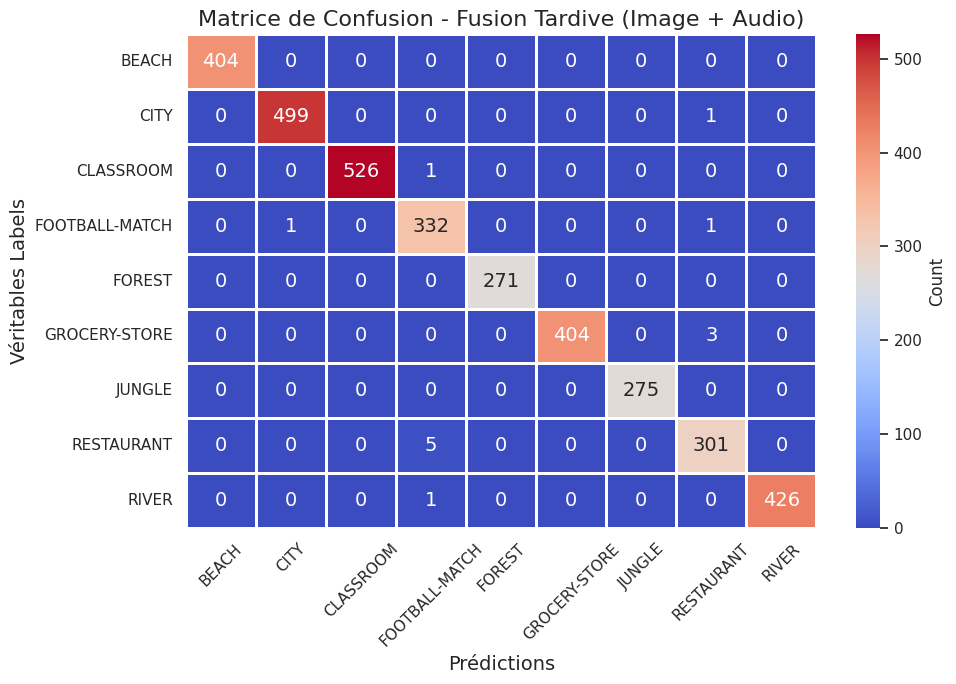

Classification Report - Fusion Tardive (Image + Audio):
                precision    recall  f1-score   support

         BEACH       1.00      1.00      1.00       404
          CITY       1.00      1.00      1.00       500
     CLASSROOM       1.00      1.00      1.00       527
FOOTBALL-MATCH       0.98      0.99      0.99       334
        FOREST       1.00      1.00      1.00       271
 GROCERY-STORE       1.00      0.99      1.00       407
        JUNGLE       1.00      1.00      1.00       275
    RESTAURANT       0.98      0.98      0.98       306
         RIVER       1.00      1.00      1.00       427

      accuracy                           1.00      3451
     macro avg       1.00      1.00      1.00      3451
  weighted avg       1.00      1.00      1.00      3451


Accuracy après fusion tardive: 99.62%

Accuracy du modèle CNN (Image): 99.54%
Accuracy du modèle LSTM (Audio): 84.24%
Accuracy après fusion tardive: 99.62%


<ipython-input-30-96b48e53b1ea>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_fusion_classes, palette="Set2", order=np.unique(y_pred_fusion_classes))


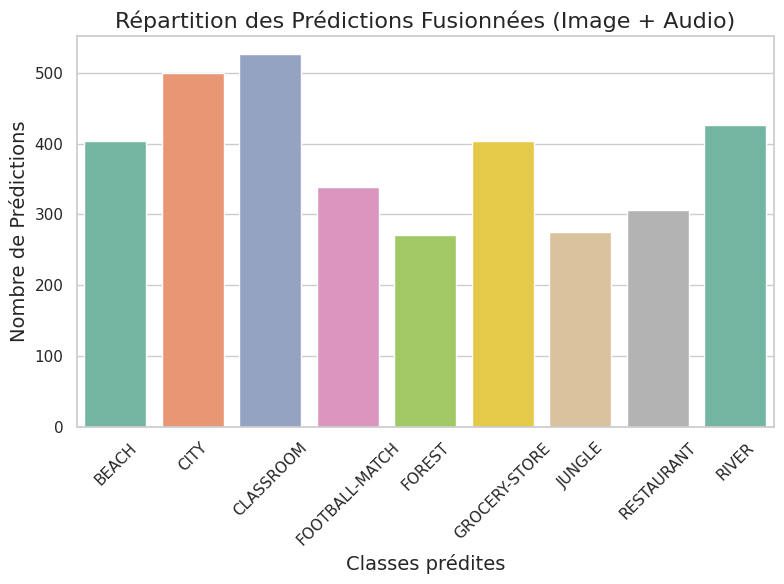

<Figure size 1500x700 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Matrice de Confusion (fusion tardive)
cm_fusion = confusion_matrix(y_test, y_pred_fusion_classes)

# Visualisation améliorée de la Matrice de Confusion
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid", palette="muted")
sns.heatmap(cm_fusion, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={"label": "Count"}, annot_kws={"size": 14}, linewidths=0.8)
plt.title('Matrice de Confusion - Fusion Tardive (Image + Audio)', fontsize=16)
plt.xlabel('Prédictions', fontsize=14)
plt.ylabel('Véritables Labels', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Rapport de classification pour la fusion tardive
print("Classification Report - Fusion Tardive (Image + Audio):")
print(classification_report(y_test, y_pred_fusion_classes, target_names=label_encoder.classes_))

# Précision après fusion tardive
accuracy_fusion = accuracy_score(y_test, y_pred_fusion_classes)
print(f'\nAccuracy après fusion tardive: {accuracy_fusion * 100:.2f}%')

# Comparaison des précisions entre les modèles (image, audio et fusion)
y_pred_img_classes = np.argmax(y_pred_img, axis=1)
y_pred_audio_classes = np.argmax(y_pred_audio, axis=1)

accuracy_img = accuracy_score(y_test, y_pred_img_classes)
accuracy_audio = accuracy_score(y_test, y_pred_audio_classes)

# Affichage comparatif
print(f"\nAccuracy du modèle CNN (Image): {accuracy_img * 100:.2f}%")
print(f"Accuracy du modèle LSTM (Audio): {accuracy_audio * 100:.2f}%")
print(f"Accuracy après fusion tardive: {accuracy_fusion * 100:.2f}%")

# Visualisation de la répartition des prédictions
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred_fusion_classes, palette="Set2", order=np.unique(y_pred_fusion_classes))
plt.title("Répartition des Prédictions Fusionnées (Image + Audio)", fontsize=16)
plt.xlabel("Classes prédites", fontsize=14)
plt.ylabel("Nombre de Prédictions", fontsize=14)
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.tight_layout()
plt.show()

# Courbes d'Accuracy et de Perte (si vous avez les historiques des deux modèles)
plt.figure(figsize=(15, 7))




plt.tight_layout()
plt.show()
